# XGBoost Classifier for Crocodile Species
This program trains a XGBoost Classifier to predict crocodile species. This program also compares baseline vs tuned XGB models and analyzes feature importance. 

All steps are modularized.

In [1]:
# Importing all of the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from collections import Counter

RANDOM_STATE = 42

## Loading in the data
Taking a look at the data as well and checking for null values. 

In [2]:
# Load in the dateset
def load_dataset(csv_path):
    df = pd.read_csv(csv_path)
    return df
df = pd.read_csv("crocodile_dataset .csv")
df.head()

,Observation ID,Common Name,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Date of Observation,Country/Region,Habitat Type,Conservation Status,Observer Name,Notes
0,1,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.0,Adult,Male,31-03-2018,Belize,Swamps,Least Concern,Allison Hill,Cause bill scientist nation opportunity.
1,2,American Crocodile,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.5,Adult,Male,28-01-2015,Venezuela,Mangroves,Vulnerable,Brandon Hall,Ago current practice nation determine operatio...
2,3,Orinoco Crocodile,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.2,Juvenile,Unknown,07-12-2010,Venezuela,Flooded Savannas,Critically Endangered,Melissa Peterson,Democratic shake bill here grow gas enough ana...
3,4,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.4,Adult,Male,01-11-2019,Mexico,Rivers,Least Concern,Edward Fuller,Officer relate animal direction eye bag do.
4,5,Mugger Crocodile (Marsh Crocodile),Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.4,Adult,Unknown,15-07-2019,India,Rivers,Vulnerable,Donald Reid,Class great prove reduce raise author play mov...


In [3]:
print(df.columns)

Index(['Observation ID', 'Common Name', 'Scientific Name', 'Family', 'Genus',
       'Observed Length (m)', 'Observed Weight (kg)', 'Age Class', 'Sex',
       'Date of Observation', 'Country/Region', 'Habitat Type',
       'Conservation Status', 'Observer Name', 'Notes'],
      dtype='object')


In [4]:
# Check for null values 
df.isna().sum()

Observation ID          0
Common Name             0
Scientific Name         0
Family                  0
Genus                   0
Observed Length (m)     0
Observed Weight (kg)    0
Age Class               0
Sex                     0
Date of Observation     0
Country/Region          0
Habitat Type            0
Conservation Status     0
Observer Name           0
Notes                   0
dtype: int64

## Data Pre-processing
- Dropping unnecessary columns
- Encoding features
- Normalization of some features

In [5]:
# This is mostly Jonathan's code; 
def preprocessing_data(crocs):
    # Removing unnecessary columns
    crocs = crocs.drop(['Observation ID', 'Scientific Name', 'Family', 'Genus', 'Conservation Status', 'Observer Name', 'Notes'], axis=1)
    
    # One hot encoding the remaining features
    crocs = pd.get_dummies(crocs, columns=['Age Class', 'Sex', 'Habitat Type', 'Country/Region'], drop_first=True)

    # Converting the data into two features, one for the month and another for the year
    crocs['Date of Observation'] = pd.to_datetime(crocs['Date of Observation'])

    # Getting month and year stats
    crocs['Year'] = crocs['Date of Observation'].dt.year
    crocs['Month'] = crocs['Date of Observation'].dt.month

    crocs = crocs.drop(columns=['Date of Observation'], axis=1)

    # Normalizing the year
    max_year = crocs.max(axis=0)['Year']
    min_year = crocs.min(axis=0)['Year']
    crocs['Year'] = (crocs['Year'] - min_year) / (max_year - min_year)

    # Normalizing the month
    crocs['Month'] = np.sin((np.pi*crocs['Month']) / 12)

    # Normalizing length and weight
    scaler = StandardScaler()
    scale = ['Observed Length (m)', 'Observed Weight (kg)']
    crocs[scale] = scaler.fit_transform(crocs[scale])

    # Creating the target and removing it from the croc dataframe
    target = crocs['Common Name']
    crocs.drop(['Common Name'], axis=1, inplace=True)

    # Returning the new dataframe and the target
    return crocs, target, scaler

In [6]:
# Encode labels for the target 
def encode_labels(y):
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    print("Species classes:", le.classes_)
    return y_enc, le

## Train-test Split and Training the Model

In [7]:
# Train-test Split 
def train_val_split(X, y_enc, test_size, random_state):
    return train_test_split(
        X,
        y_enc,
        test_size=test_size,
        stratify=y_enc,
        random_state=random_state
    )

In [8]:
# Train the model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

## Build the XGB Classifier

In [9]:
# Build the classifier
def build_xgb_classifier(num_classes, random_state):
    model = XGBClassifier(
        objective="multi:softprob",
        num_class=num_classes,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=random_state,
        tree_method="hist",  
        n_jobs=-1
    )
    return model

## Evaluation Metrics
Accuracy Score, AUC Score and a Confusion Matrix was used to evaluate performance

In [10]:
# Evaluation of model
def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}\n")
    
    try:
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
        print(f"Multiclass AUC (macro-averaged): {auc:.4f}")
    except Exception as e:
        print("AUC could not be calculated:", e)


    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)



In [11]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

## Feature Importance Analysis

In [12]:
# What features were most important
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    idx_sorted = np.argsort(importances)[::-1]

    top_n = min(20, len(feature_names))
    top_idx = idx_sorted[:top_n]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=importances[top_idx],
        y=np.array(feature_names)[top_idx]
    )
    plt.title("Top Feature Importances (XGBoost)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

## Hyperparameter Tuning

In [13]:
# Add some hyperparameter tuning
def get_param_distributions():
    param_distributions = {
        "n_estimators": [200, 300, 400, 500],
        "max_depth": [3, 4, 5, 6, 8],
        "learning_rate": [0.01, 0.03, 0.05, 0.1],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "min_child_weight": [1, 3, 5],
        "gamma": [0, 0.1, 0.3, 0.5],
    }
    return param_distributions

In [14]:
# Find the best XGB model 
def hyperparameter_search(
    X_train,
    y_train,
    num_classes: int,
    n_iter: int = 25,
    cv: int = 3
):
    
    base_model = build_xgb_classifier(num_classes, RANDOM_STATE)
    param_distributions = get_param_distributions()

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        # Number of combinations to try
        n_iter=n_iter,         
        scoring="accuracy",
        cv=cv,
        verbose=2,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    search.fit(X_train, y_train)

    print("\nBest parameters found:")
    print(search.best_params_)
    print(f"Best CV accuracy: {search.best_score_:.4f}")

    best_model = search.best_estimator_
    return best_model

In [15]:
def run_full_pipeline(csv_path, tuning_iterations):
    # 1. Load dataset
    df = load_dataset(csv_path)
    print("Raw data shape:", df.shape)

    # 2. Preprocess (your function)
    X, y_raw, scaler = preprocessing_data(df)
    print("After preprocessing - X shape:", X.shape)

    # 3. Encode labels
    y_enc, le = encode_labels(y_raw)
    num_classes = len(le.classes_)
    print("Number of classes (species):", num_classes)

    # 4. Train/test split
    X_train, X_test, y_train, y_test = train_val_split(X, y_enc, 0.2, RANDOM_STATE)

    # 5. Train baseline and tuned model
    print("\n=== Training baseline XGBoost model ===")
    model = build_xgb_classifier(num_classes, RANDOM_STATE)
    model.fit(X_train, y_train)

    print("\n=== Hyperparameter tuning XGBoost ===")
    model_tuned = hyperparameter_search(
    X_train,
    y_train,
        num_classes=num_classes,
        n_iter=tuning_iterations,
        cv=3
    )

    # 6. Evaluate
    print("\n=== Evaluation on test set ===")
    print("\nEvaluation on the baseline model: ")
    evaluate_model(model, X_test, y_test, le)

    print("\nEvaluation on the tuned model: ")
    evaluate_model(model_tuned, X_test, y_test, le)

    # 7. Feature importance
    print("\n=== Feature importances ===")
    plot_feature_importance(model, X.columns)

    return model, le, X.columns

Raw data shape: (1000, 15)
After preprocessing - X shape: (1000, 83)
Species classes: ['American Crocodile' 'Borneo Crocodile (disputed)'
 'Central African Slender-snouted Crocodile' 'Congo Dwarf Crocodile'
 'Cuban Crocodile' "Freshwater Crocodile (Johnstone's)"
 "Hall's New Guinea Crocodile" "Morelet's Crocodile"
 'Mugger Crocodile (Marsh Crocodile)' 'New Guinea Crocodile'
 'Nile Crocodile' 'Orinoco Crocodile' 'Philippine Crocodile'
 'Saltwater Crocodile' 'Siamese Crocodile' 'West African Crocodile'
 'West African Dwarf Crocodile' 'West African Slender-snouted Crocodile']
Number of classes (species): 18

=== Training baseline XGBoost model ===


/var/folders/w3/p67v3fjx07738bb18_j9jqhr0000gn/T/ipykernel_84889/3366147736.py:10: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  crocs['Date of Observation'] = pd.to_datetime(crocs['Date of Observation'])



=== Hyperparameter tuning XGBoost ===
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best parameters found:
{'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best CV accuracy: 0.9600

=== Evaluation on test set ===

Evaluation on the baseline model: 
Accuracy: 0.9750

Multiclass AUC (macro-averaged): 0.9990


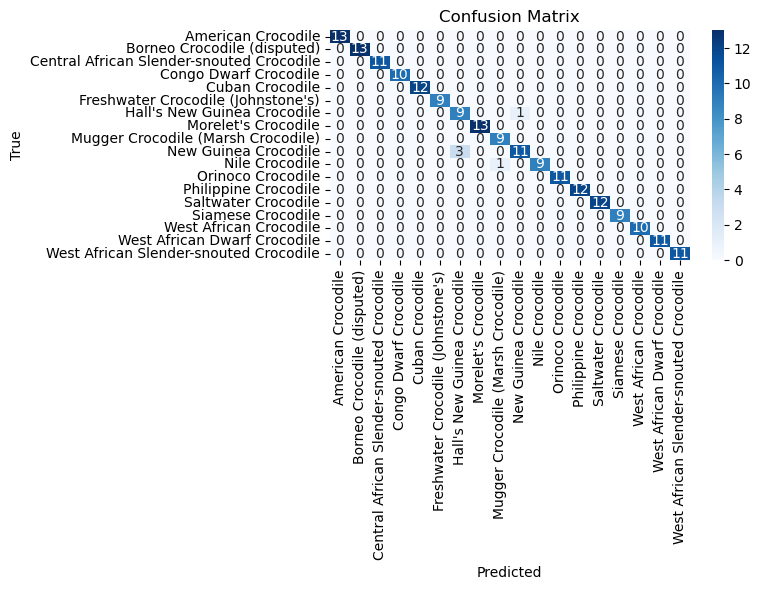


Evaluation on the tuned model: 
Accuracy: 0.9750

Multiclass AUC (macro-averaged): 0.9988


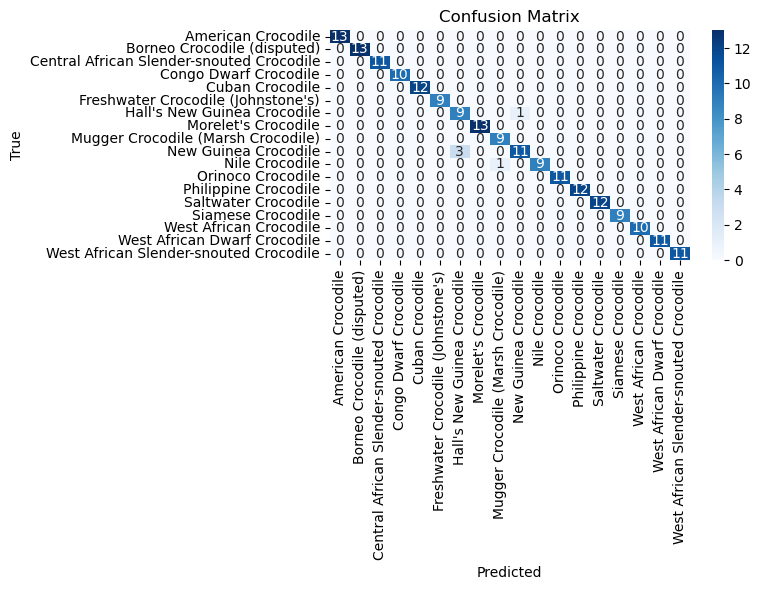


=== Feature importances ===


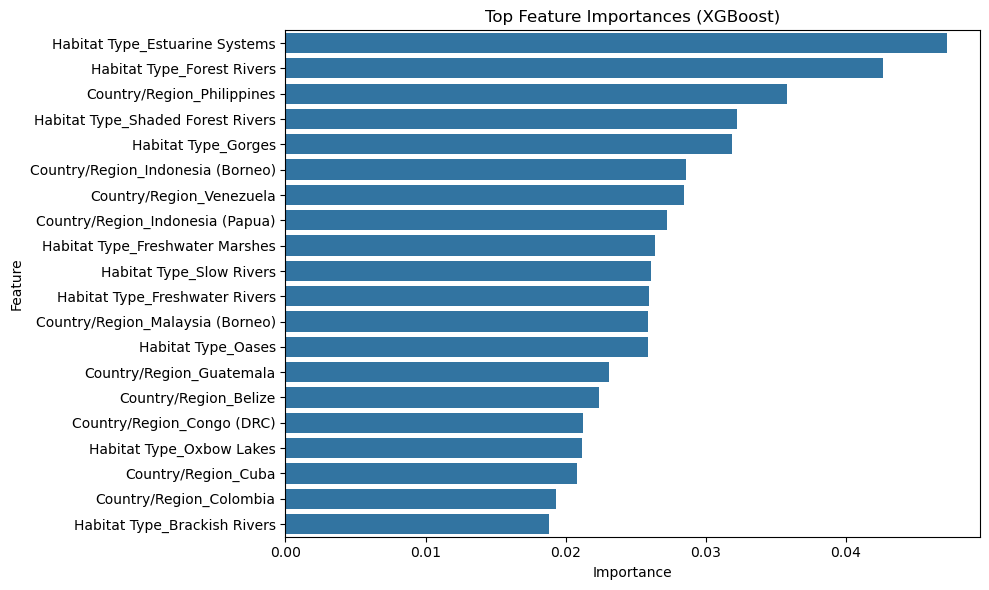

In [16]:
model, label_encoder, feature_names = run_full_pipeline('crocodile_dataset .csv', 50)